Sources: 

-https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/

-https://tedboy.github.io/statsmodels_doc/generated/generated/statsmodels.tsa.api.VAR.html

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import pylab
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats.distributions import chi2
from pmdarima import auto_arima
from arch import arch_model
from statsmodels.tsa.api import VAR

In [4]:
dax =  pd.read_csv("^GDAXI.csv")
nikkei = pd.read_csv("^N225.csv")
nasdaq = pd.read_csv("^IXIC.csv")

In [5]:
nasdaq = nasdaq.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"])
nikkei = nikkei.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"])
dax = dax.drop(columns=["Open", "High", "Low", "Adj Close", "Volume"])

In [6]:
nasdaq.Date = pd.to_datetime(nasdaq.Date, dayfirst = False)
nasdaq.set_index("Date", inplace = True)
nasdaq = nasdaq.asfreq("b")
nasdaq = nasdaq.fillna(method = "ffill")
nasdaq["nasdaq"] = nasdaq.Close
del nasdaq["Close"]

nikkei.Date = pd.to_datetime(nikkei.Date, dayfirst = False)
nikkei.set_index("Date", inplace = True)
nikkei = nikkei.asfreq("b")
nikkei = nikkei.fillna(method = "ffill")
nikkei["nikkei"] = nikkei.Close
del nikkei["Close"]

dax.Date = pd.to_datetime(dax.Date, dayfirst = False)
dax.set_index("Date", inplace = True)
dax = dax.asfreq("b")
dax = dax.fillna(method = "ffill")
dax["dax"] = dax.Close
del dax["Close"]

In [8]:
df_comp = pd.merge(pd.merge(nasdaq, nikkei, how = "outer", on = "Date"), dax, how = "outer", on = "Date")

In [9]:
df_comp

,nasdaq,nikkei,dax
Date,,,
1994-01-07,782.940002,18124.009766,2224.949951
1994-01-10,786.690002,18443.439453,2225.000000
1994-01-11,785.520020,18485.250000,2228.100098
1994-01-12,786.869995,18793.880859,2182.060059
1994-01-13,787.809998,18577.259766,2142.370117
...,...,...,...
2019-08-26,7853.740234,20261.039063,11658.040039
2019-08-27,7826.950195,20456.080078,11730.019531
2019-08-28,7856.879883,20479.419922,11701.019531


In [10]:
df_comp["ret_nasdaq"] = df_comp.nasdaq.pct_change(1).mul(100)
df_comp["ret_nikkei"] = df_comp.nikkei.pct_change(1).mul(100)
df_comp["ret_dax"] = df_comp.dax.pct_change(1).mul(100)

df_comp["norm_ret_nasdaq"] = df_comp.ret_nasdaq.div(df_comp.ret_nasdaq[1]).mul(100)
df_comp["norm_ret_nikkei"] = df_comp.ret_nikkei.div(df_comp.ret_nikkei[1]).mul(100)
df_comp["norm_ret_dax"] = df_comp.ret_dax.div(df_comp.ret_dax[1]).mul(100)

df_comp = df_comp.asfreq("b")

In [11]:
df_comp

,nasdaq,nikkei,dax,ret_nasdaq,ret_nikkei,ret_dax,norm_ret_nasdaq,norm_ret_nikkei,norm_ret_dax
Date,,,,,,,,,
1994-01-07,782.940002,18124.009766,2224.949951,NaN,NaN,NaN,NaN,NaN,NaN
1994-01-10,786.690002,18443.439453,2225.000000,0.478964,1.762467,0.002249,100.000000,100.000000,100.000000
1994-01-11,785.520020,18485.250000,2228.100098,-0.148722,0.226696,0.139330,-31.050798,12.862428,6193.986426
1994-01-12,786.869995,18793.880859,2182.060059,0.171857,1.669606,-2.066336,35.881095,94.731198,-91859.870071
1994-01-13,787.809998,18577.259766,2142.370117,0.119461,-1.152615,-1.818921,24.941552,-65.397822,-80860.906555
...,...,...,...,...,...,...,...,...,...
2019-08-26,7853.740234,20261.039063,11658.040039,1.315444,-2.172145,0.400725,274.643716,-123.244604,17814.422598
2019-08-27,7826.950195,20456.080078,11730.019531,-0.341112,0.962641,0.617424,-71.218698,54.618937,27447.833867
2019-08-28,7856.879883,20479.419922,11701.019531,0.382393,0.114097,-0.247229,79.837483,6.473729,-10990.668385


In [12]:
df = df_comp.iloc[:int(len(df_comp)*0.8)]
df_test = df_comp.iloc[int(len(df_comp)*0.8):]

In [ ]:
df.tail()

,nasdaq,nikkei,dax,ret_nasdaq,ret_nikkei,ret_dax,norm_ret_nasdaq,norm_ret_nikkei,norm_ret_dax
Date,,,,,,,,,
2014-07-08,4391.459961,15314.410156,9772.669922,-1.349420,-0.422839,-1.346653,-281.737263,-23.991315,-59866.040885
2014-07-09,4419.029785,15302.650391,9808.200195,0.627805,-0.076789,0.363568,131.075729,-4.356898,16162.560207
2014-07-10,4396.200195,15216.469727,9659.129883,-0.516620,-0.563175,-1.519854,-107.861982,-31.953776,-67565.762223
2014-07-11,4415.490234,15164.040039,9666.339844,0.438789,-0.344559,0.074644,91.612104,-19.549803,3318.331360
2014-07-14,4440.419922,15296.820313,9783.009766,0.564596,0.875626,1.206971,117.878644,49.681837,53656.419584


In [ ]:
df_test.head()

,nasdaq,nikkei,dax,ret_nasdaq,ret_nikkei,ret_dax,norm_ret_nasdaq,norm_ret_nikkei,norm_ret_dax
Date,,,,,,,,,
2014-07-15,4416.390137,15395.160156,9719.410156,-0.541160,0.642878,-0.650103,-112.985590,36.476013,-28900.596539
2014-07-16,4425.970215,15379.299805,9859.269531,0.216921,-0.103022,1.438970,45.289636,-5.845311,63970.024234
2014-07-17,4363.450195,15370.259766,9753.879883,-1.412572,-0.058781,-1.068940,-294.922452,-3.335130,-47520.177725
2014-07-18,4432.149902,15215.709961,9720.019531,1.574435,-1.005512,-0.347148,328.716933,-57.051395,-15432.593157
2014-07-21,4424.700195,15215.709961,9612.049805,-0.168083,0.000000,-1.110797,-35.093119,0.000000,-49380.979864


In [13]:
start_date = "2014-07-15"
end_date = "2015-01-01"

### Forecasting volatility

In [15]:
model_garch = arch_model(df_comp.ret_nasdaq[1:], mean = "Constant", vol = "GARCH", p = 1, q = 1, dist = "Normal")
results_garch = model_garch.fit(last_obs = start_date) # Close the forecasting fit window at the beginning of the test set.
results_garch.summary()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 17317413490.223248
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2913902183.958739
Iteration:      3,   Func. Count:     22,   Neg. LLF: 8839.484891809401
Iteration:      4,   Func. Count:     28,   Neg. LLF: 8787.564672543456
Iteration:      5,   Func. Count:     34,   Neg. LLF: 9309.864492820841
Iteration:      6,   Func. Count:     41,   Neg. LLF: 8750.68612668519
Iteration:      7,   Func. Count:     47,   Neg. LLF: 8833.849782685098
Iteration:      8,   Func. Count:     53,   Neg. LLF: 8763.165324897935
Iteration:      9,   Func. Count:     59,   Neg. LLF: 8746.80774331736
Iteration:     10,   Func. Count:     64,   Neg. LLF: 8746.758952391
Iteration:     11,   Func. Count:     69,   Neg. LLF: 8746.758577001467
Iteration:     12,   Func. Count:     74,   Neg. LLF: 8746.758572190543
Iteration:     13,   Func. Count:     79,   Neg. LLF: 8746.758571559443
Optimization terminated successfully    (Exit mode 0)
            Cu

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:             ret_nasdaq   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -8746.76
Distribution:                  Normal   AIC:                           17501.5
Method:            Maximum Likelihood   BIC:                           17527.9
                                        No. Observations:                 5351
Date:                Tue, Mar 26 2024   Df Residuals:                     5350
Time:                        10:41:15   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0845  1.459e-02      5.790  7.037e-09 [5.587e-02,  0.113]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega          0.0162  4.477e-03      3.620  2.941e-04 [7.434e-03,2.498e-02]
alpha[1]       0.0823  1.122e-02      7.335  2.211e-13   [6.030e-02,  0.104]
beta[1]        0.9111  1.145e-02     79.601      0.000     [  0.889,  0.934]
============================================================================

Covariance estimator: robust
"""

In [16]:
pred_garch = results_garch.forecast(horizon = 1, align = "target", reindex = True)

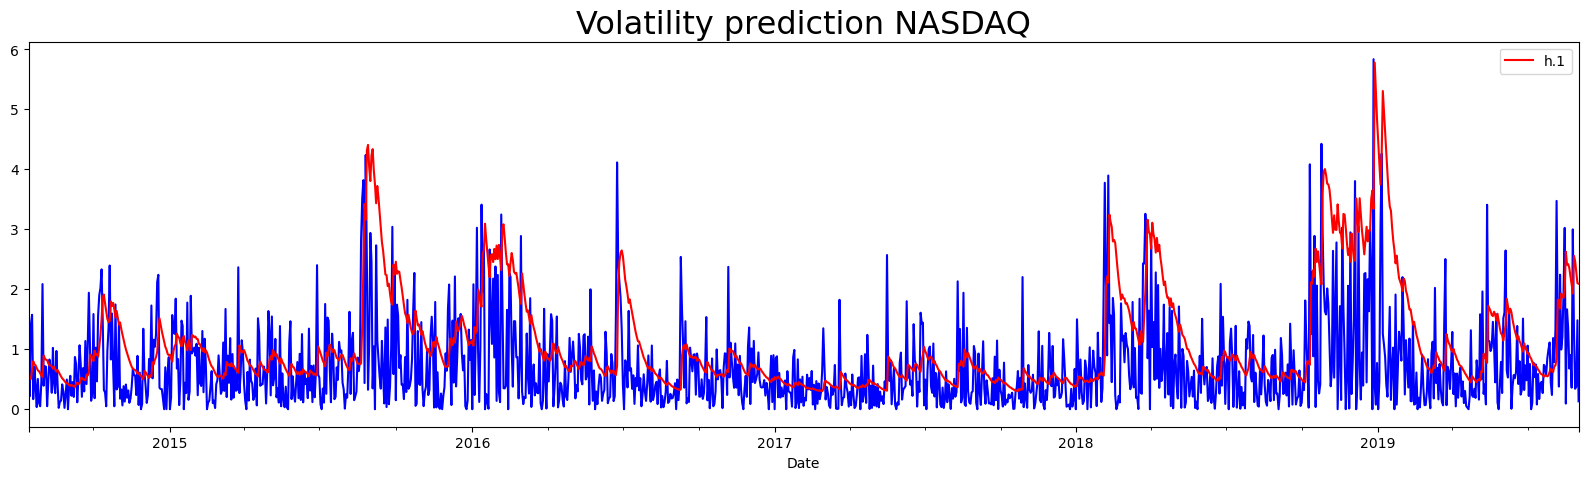

In [17]:
pred_garch.residual_variance[start_date:].plot(figsize = (20,5), color = "red", zorder = 2)
df_test.ret_nasdaq[start_date:].abs().plot(color = "blue", zorder = 1)
plt.title("Volatility prediction NASDAQ", size = 23)
plt.show()

In [30]:
pred_garch = results_garch.forecast(horizon = 100, align = "target", reindex = True)

In [19]:
pred_garch.residual_variance[-1:]

,h.001,h.002,h.003,h.004,h.005,h.006,h.007,h.008,h.009,h.010,...,h.091,h.092,h.093,h.094,h.095,h.096,h.097,h.098,h.099,h.100
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-30,2.092921,2.105024,2.284297,2.470191,2.554214,1.947351,2.097481,2.21932,2.358531,2.421838,...,1.375386,1.398563,1.418861,1.371128,1.391437,1.413278,1.436486,1.460305,1.484124,1.509966


### Multivariate forecasting

In [20]:
df_ret = df[["ret_nasdaq", "ret_nikkei", "ret_dax"]][1:]

In [21]:
model_var_ret = VAR(df_ret)
model_var_ret.select_order(15)
results_var_ret = model_var_ret.fit(ic = "aic")
results_var_ret.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 26, Mar, 2024
Time:                     10:41:39
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    1.87287
Nobs:                     5346.00    HQIC:                   1.83441
Log likelihood:          -27557.1    FPE:                    6.13344
AIC:                      1.81376    Det(Omega_mle):         6.07870
--------------------------------------------------------------------
Results for equation ret_nasdaq
                   coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------
const                 0.047771         0.021551            2.217           0.027
L1.ret_nasdaq        -0.040656         0.016125           -2.521           0.012
L1.ret_nikkei        -0.018646         0.016669        

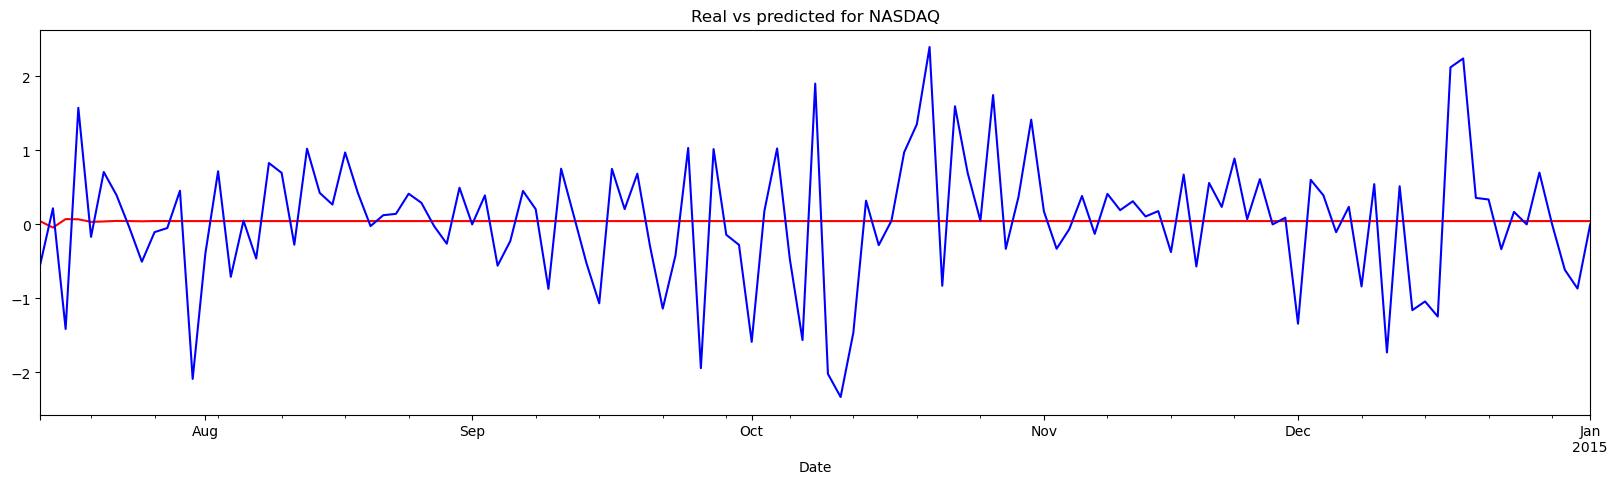

In [40]:
lag_order_ret = results_var_ret.k_ar
var_pred_ret = results_var_ret.forecast(y = df_ret.values[-lag_order_ret:], steps = len(df_test[start_date:end_date]))

df_ret_pred = pd.DataFrame(data = var_pred_ret, index = df_test[start_date:end_date].index, columns = df_test[start_date:end_date].columns[3:6])

df_ret_pred.ret_nasdaq[start_date:end_date].plot(figsize = (20,5), color = "red")
df_test.ret_nasdaq[start_date:end_date].plot(color = "blue")
plt.title("Real vs predicted for NASDAQ")
plt.show()

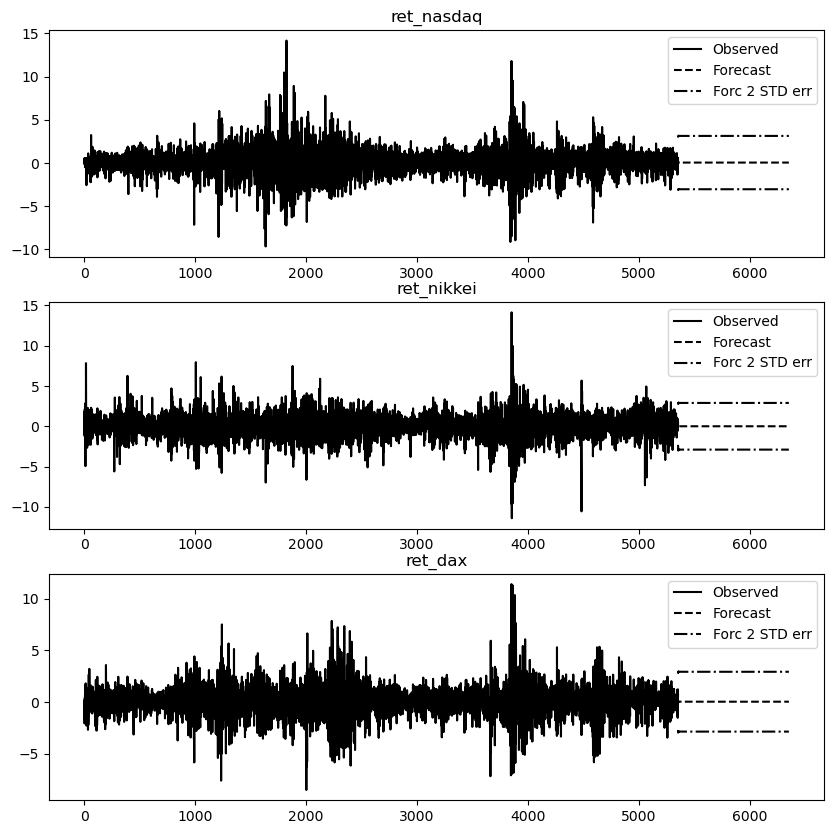

In [39]:
results_var_ret.plot_forecast(1000)
plt.show()